
![alt text](https://www.agn.gob.ar/themes/agn/images/logo-blue.png "Title")
# Curso de detección de anomalías - TP integrador Final<br>
### Argentina - AGN - Equipo II

> Cecilia Móndolo  `cmondolo@agn.gov.ar`<br>
> Cristian Ferro  `cferro@agn.gov.ar`<br>
> Mariano Parada   `mparada@agn.gov.ar`<br>

In [1]:
# jfzeac@unal.edu.co
# asunto Curso Anomalías
# Fecha de Entrega Domingo 25

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import confusion_matrix
import random
from plotnine import ggplot, geom_point, aes, geom_abline
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import t, zscore
import warnings
warnings.filterwarnings("ignore")

### Leemos los datos desde el csv local (para que sea leído correctamente hubo que setear el encoding en latin-1)

In [3]:
#Leemos los datos
df = pd.read_csv('regalias_viasterciarias.csv', index_col=[0], encoding='latin-1')
df.head(3)

,id_proyecto,nombre_del_proyecto,nombre_ocad,region,departamento,sector_suifp,programa,subprograma,avance_fisico,avance_financiero,estado_detalle,estado_general,anno,valor_sgr,valor_nación,valor_otros,total_proyecto,pctg_sgr
1,id_357417,CONSTRUCCIÓN DE PLACA HUELLA EN VÍAS TERCIARIA...,Región Eje Cafetero,Eje Cafetero,Antioquia,Transporte,Infraestructura Red Vial Regional,Red Vial Terciaria,100.0,100.00,Cerrado,Terminado,2017,1784417,0,0,1784417,100.0
2,id_357587,CONSTRUCCIÓN DE PLACA HUELLA EN VÍAS TERCIARIA...,Región Eje Cafetero,Eje Cafetero,Antioquia,Transporte,Infraestructura Red Vial Regional,Red Vial Terciaria,100.0,100.00,Cerrado,Terminado,2017,756224,0,0,756224,100.0
3,id_701595,MEJORAMIENTO DE VÍAS TERCIARIAS EN LOS MUNICIP...,Región Eje Cafetero,Eje Cafetero,Antioquia,Transporte,Infraestructura Red Vial Regional,Red Vial Terciaria,100.0,99.95,Cerrado,Terminado,2018,1605476,0,333,1605809,100.0


# Punto 1
1.	Utilizando la metodología de Cox-Tukey lleve a cabo la identificación de proyectos de arreglos de vías terciarias con valores extremos en el total de proyectos.
Elabore un histograma de la variable transformada.

### Verificamos cantidad de instancias, tipos de datos, nombre de las columnas y que no hayan valores faltantes

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 207 entries, 1 to 207
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id_proyecto          207 non-null    object 
 1   nombre_del_proyecto  207 non-null    object 
 2   nombre_ocad          207 non-null    object 
 3   region               207 non-null    object 
 4   departamento         207 non-null    object 
 5   sector_suifp         207 non-null    object 
 6   programa             207 non-null    object 
 7   subprograma          207 non-null    object 
 8   avance_fisico        207 non-null    float64
 9   avance_financiero    207 non-null    float64
 10  estado_detalle       207 non-null    object 
 11  estado_general       207 non-null    object 
 12  anno                 207 non-null    int64  
 13  valor_sgr            207 non-null    int64  
 14  valor_nación         207 non-null    int64  
 15  valor_otros          207 non-null    int

### Analizamos la distribución de las variables numéricas con **describe**

In [5]:
(round(df.describe(), ndigits=2))

,avance_fisico,avance_financiero,anno,valor_sgr,valor_nación,valor_otros,total_proyecto,pctg_sgr
count,207.00,207.00,207.00,207.00,207.00,207.00,207.00,207.00
mean,99.07,98.52,2017.71,435770.83,16103.06,4996.17,456870.06,98.01
std,6.38,6.84,0.87,1343965.59,231682.66,28247.36,1373224.41,9.56
min,22.29,21.72,2016.00,6882.00,0.00,0.00,6882.00,20.60
25%,100.00,99.72,2017.00,92286.00,0.00,0.00,95251.50,100.00
50%,100.00,99.96,2018.00,178367.00,0.00,0.00,185539.00,100.00
75%,100.00,99.99,2018.00,455833.00,0.00,0.00,469039.50,100.00
max,100.12,100.08,2020.00,18193397.00,3333333.00,260833.00,18193397.00,100.00


### Chequemos que todos los subprogramas sean de "Red Vial Terciaria"

In [6]:
df.subprograma.value_counts()

Red Vial Terciaria    207
Name: subprograma, dtype: int64

### Graficamos el histograma

<AxesSubplot:>

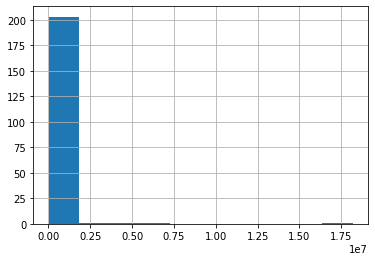

In [7]:
df.total_proyecto.hist()

### En base a la figura del histograma, vamos escalar los datos de "total_proyecto" utilizando **stats.boxcox**.
Luego graficaremos para verificar si escalando los datos nos acercamos a una distribución normal.

In [8]:
# Transformación de Box-Cox (Dupla: arreglo de valores transformados y lambda)
x = df.total_proyecto
y, fitted_lambda = stats.boxcox(x)

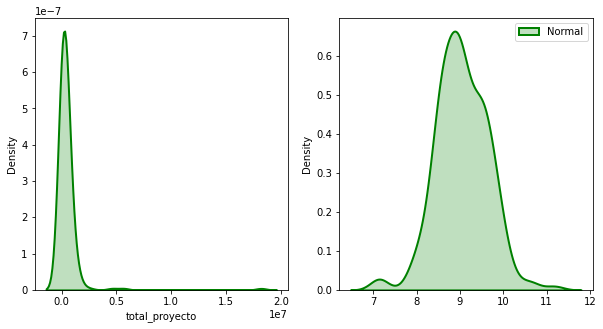

In [9]:
# crear ejes para el gráfico: 1 fila 2 columnas
fig, ax = plt.subplots(1, 2)
# graficando la variable en su manera original y luego de transformada
sns.distplot(x, hist = False, kde = True,
kde_kws = {'shade': True, 'linewidth': 2},
label = "Non-Normal", color ="green", ax = ax[0])
sns.distplot(y, hist = False, kde = True,
kde_kws = {'shade': True, 'linewidth': 2},
label = "Normal", color ="green", ax = ax[1])
# Anadiendo leyenda a los gráficos
plt.legend(loc = "upper right")
# re-escalando los subplots
fig.set_figheight(5)
fig.set_figwidth(10)
plt.show()
# Se restituyen los valores a 1 fila 1 columna para los plots
#fig, ax = plt.subplots(1, 1)

a.	El valor de lambda es -0.051858459461380214

In [10]:
print(f"El valor de Lambda utilizado para la transformación es : {fitted_lambda}")

El valor de Lambda utilizado para la transformación es : -0.051858459461380214


b.	Identifique una vez estén los valores transformados los outliers detectados con la regla de Tukey (utilice un valor de k igual a 1,5). El número de valores extremos identificados es: 4

In [11]:
# Esta función recibe dos parámetros, "x" que es el conjunto de datos, y "k" que es el rango.
def fivenum(x, k, nan_remove = True):
  """Devuelve los cinco números de Tukey (mínimo, bigote inferior, mediana,
  bigote superior, maximo) para una lista, arreglo univariado de numpy o serie de pandas"""

  if(isinstance(x, list)):
        x = np.array(x)
  try:
        np.sum(x)
  except TypeError :
        print('Error: debe proveer una lista o un arreglo de sólo números')
  if (nan_remove == True):
        y = x[~np.isnan(x)]
        q1 = np.percentile(y, 25)
        q3 = np.percentile(y,75)
        md = np.median(y)
        RI = q3-q1
        lower_whisker = q1 - k * RI
        upper_whisker = q3 + k * RI
        lower_whisker = np.max([lower_whisker, np.min(y)])
        upper_whisker = np.min([upper_whisker, np.max(y)])

  else:
        q1 = np.percentile(x, 25)
        q3 = np.percentile(x,75)
        md = np.median(x)
        RI = q3-q1
        lower_whisker = q1 - k * RI
        upper_whisker = q3 + k * RI
        lower_whisker = np.max([lower_whisker, np.min(x)])
        upper_whisker = np.min([upper_whisker, np.max(x)])

  salida = np.array([lower_whisker, q1, md, q3, upper_whisker])
  return [salida]

In [12]:
df['total_proyectos_std'] = y
df.head(3)

,id_proyecto,nombre_del_proyecto,nombre_ocad,region,departamento,sector_suifp,programa,subprograma,avance_fisico,avance_financiero,estado_detalle,estado_general,anno,valor_sgr,valor_nación,valor_otros,total_proyecto,pctg_sgr,total_proyectos_std
1,id_357417,CONSTRUCCIÓN DE PLACA HUELLA EN VÍAS TERCIARIA...,Región Eje Cafetero,Eje Cafetero,Antioquia,Transporte,Infraestructura Red Vial Regional,Red Vial Terciaria,100.0,100.00,Cerrado,Terminado,2017,1784417,0,0,1784417,100.0,10.142389
2,id_357587,CONSTRUCCIÓN DE PLACA HUELLA EN VÍAS TERCIARIA...,Región Eje Cafetero,Eje Cafetero,Antioquia,Transporte,Infraestructura Red Vial Regional,Red Vial Terciaria,100.0,100.00,Cerrado,Terminado,2017,756224,0,0,756224,100.0,9.726234
3,id_701595,MEJORAMIENTO DE VÍAS TERCIARIAS EN LOS MUNICIP...,Región Eje Cafetero,Eje Cafetero,Antioquia,Transporte,Infraestructura Red Vial Regional,Red Vial Terciaria,100.0,99.95,Cerrado,Terminado,2018,1605476,0,333,1605809,100.0,10.092259


### Usamos la función fivenum pasandole como perámetros total_proyectos_std y como k= 1.5 e imprimimos los 5 números de Tukey:

In [13]:
nros_tukey = fivenum(df.total_proyectos_std,1.5)
nros_tukey

[array([ 7.37585734,  8.64218714,  9.00386433,  9.48640701, 10.7527368 ])]

In [14]:
df['outlier_proyectos'] = df['total_proyectos_std'].apply(lambda x: 'outlier' if (x < nros_tukey[0][0]) | (x > nros_tukey[0][4]) else 'no_outlier')

In [15]:
# Contamos los outliers:
outliers = df.outlier_proyectos[df.outlier_proyectos =='outlier'].count()

In [16]:
print ("El número de valores extremos identificados según los números de Tukey es de: ", outliers)

El número de valores extremos identificados según los números de Tukey es de:  4


c.	Si repite el valor de b con k = 3. El número de valores extremos es:<BR>

In [17]:
nros_tukey = fivenum(df.total_proyectos_std,3)
nros_tukey

[array([ 7.08880133,  8.64218714,  9.00386433,  9.48640701, 11.17938738])]

In [18]:
df['outlier_proyectos'] = df['total_proyectos_std'].apply(lambda x: 'outlier' if (x < nros_tukey[0][0]) | (x > nros_tukey[0][4]) else 'no_outlier')
df.outlier_proyectos.value_counts()

no_outlier    207
Name: outlier_proyectos, dtype: int64

Al cambiar el rango de 1.5 a 3, no se detectan outliers.

# Punto 2

2.	Considere las variables valor_sgr, valor_nación, valor_otros, total_proyecto, 
Y pctg_sgr, lleve a cabo la identificación de valores outliers utilizando la medida de identificación de outliers “local_outlier factor”.  Considere un 10% de valores anómalos


In [19]:
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import confusion_matrix
from plotnine import ggplot, geom_point, aes, geom_abline
from sklearn import preprocessing

In [20]:
# ajuste el modelo
df_lof = df[["valor_sgr", "valor_nación", "valor_otros", "total_proyecto", "pctg_sgr"]]
# Usamos preprocessing.scale de SkLearn para llevar los valores de las 5 columnas a valores comparables
# sino estaremos comparando variables con valores inliers muy disímiles
df_estandariz = preprocessing.scale(df_lof)
# El scale devuelve arrays por lo que tenemos que rearmar el DataFrame
df_estandariz = pd.DataFrame(data=df_estandariz,columns=["valor_sgr", "valor_nación", "valor_otros", "total_proyecto", "pctg_sgr"])
clf = LocalOutlierFactor(n_neighbors = 5, contamination = 0.1) # esto es para que identifique un 10% de datos outliers
# use fit_predict para calcular el número de errores al comparar
y_pred = clf.fit_predict(df_estandariz)
#Agregamos una columna que identifica los outlayers y le asignamos el resultado de y_pred
df_lof['outlier'] = y_pred
#Contamos la cantidad de outliers

# a.	El número de valores outliers identificados son:

In [21]:
print("Los outliers son: ", len(df_lof[df_lof.outlier == -1]))

Los outliers son:  20


In [22]:
#Generamos los valores de densidad de LOF y los agregamos a una columna
X_scores = clf.negative_outlier_factor_
df_lof['xscore'] = X_scores

### Algunas conversiones :

In [23]:
#Convertimos el SCORE a positivo:
df_lof['xscore'] =  df_lof['xscore']*-1
#Pegamos ID_PROYECTO al DataFrame transformado
df_lof['id_proyecto'] = df['id_proyecto']
#Agregamos el nombre del proyecto del dataframe original
df_lof['nombre_del_proyecto'] = df['nombre_del_proyecto']

### Analizamos la distribucion de valores del Xscore

In [24]:
df_lof['xscore'].describe()

count    207.000000
mean       2.081988
std        5.090888
min        0.912773
25%        0.989901
50%        1.044030
75%        1.227510
max       44.753128
Name: xscore, dtype: float64

# b. El proyecto con mayor valor LOF es: 1028007

In [25]:
#guardamos el proyecto en otra variable:
df_mayor = df_lof.loc[24]
print("La mayor densidad LOF es: ", df_mayor.xscore)

La mayor densidad LOF es:  44.75312804506973


In [26]:
print("El proyecto cuya densidad LOF es mayor es: ", df_mayor.id_proyecto)

El proyecto cuya densidad LOF es mayor es:  id_1028007


In [27]:
print("Información del proyecto: ", df_mayor)

Información del proyecto:  valor_sgr                                                          58488
valor_nación                                                           0
valor_otros                                                         3509
total_proyecto                                                     61997
pctg_sgr                                                            94.3
outlier                                                               -1
xscore                                                         44.753128
id_proyecto                                                   id_1028007
nombre_del_proyecto    MEJORAMIENTO DE LA VÍA LLUVIOSOS - ESCALONES, ...
Name: 24, dtype: object


# c.	Utilizando las mismas variables identifique los proyectos de regalías con un valor de LOF mayor a 3.  El número de valores outliers identificados son:

In [28]:
# Filtramos los proyectos cuyo LOF sea mayor a 3
df_lof.nombre_del_proyecto[df_lof.xscore > 3]

20     MEJORAMIENTO EN PAVIMENTO ASFÁLTICO DE LA VÍA ...
24     MEJORAMIENTO DE LA VÍA LLUVIOSOS - ESCALONES, ...
47     MEJORAMIENTO DE VÍAS TERCIARIAS, MEDIANTE EL U...
57     FORTALECIMIENTO DE LA INTERCOMUNICACIÓN REGION...
63     MEJORAMIENTO DE LA VÍA TERCIARIA LOS MARTÍNEZ ...
69     FORTALECIMIENTO SOCIOECONOMICO REGIONAL MEDIAN...
86     MEJORAMIENTO DE LA VÍA RURAL DE LAS BOCAS A LO...
108    MEJORAMIENTO DE LA VÍA QUE CONDUCE DE LENGUAZA...
165    MEJORAMIENTO DE VÍAS TERCIARIAS MEDIANTE EL US...
175    MEJORAMIENTO DE VIAS TERCIARIAS, CONSISTENTE E...
Name: nombre_del_proyecto, dtype: object

In [29]:
len (df_lof[df_lof.xscore > 3])

10

# 3.	Considere las variables valor_sgr, valor_nación, valor_otros, total_proyecto, Y pctg_sgr, lleve a cabo la identificación de valores outliers utilizando isolation forest.
a. Por defecto, selecciona el 10% de los registros como outliers. La pregunta es: El número de proyectos que coinciden con el 10% de los proyectos con mayor LOF es: 

In [30]:
#Importamos las librerías
from sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings("ignore")

In [31]:
#Instanciamos IsolationForest con una contaminación del 10%
model=IsolationForest(n_estimators = 50, contamination = float(0.1), max_features = 1.0,max_samples = 'auto')

In [32]:
#Seleccionamos las columnas a utilizar y las guardamos en df_isolation
df_isolation = df_lof[["valor_sgr", "valor_nación", "valor_otros", "total_proyecto", "pctg_sgr"]]
model.fit(df_isolation)

IsolationForest(contamination=0.1, n_estimators=50)

In [33]:
#Agregamos el id y nombre del proyecto al nuevo DataFrame
df_isolation['id_proyecto'] = df_lof['id_proyecto']
df_isolation['nombre_del_proyecto'] = df_lof['nombre_del_proyecto']

In [34]:
#Utilizamos los métodos decision_function y predict para crear las columnas : puntaje y anomalo
df_isolation['puntaje'] = model.decision_function(df_isolation[["valor_sgr", "valor_nación", "valor_otros", "total_proyecto", "pctg_sgr"]])
df_isolation['anomalo'] = model.predict(df_isolation[["valor_sgr", "valor_nación", "valor_otros", "total_proyecto", "pctg_sgr"]])

In [35]:
#Contamos la cantidad de instancias inlier (1) y outlier (-1)
df_isolation.anomalo.value_counts()

 1    186
-1     21
Name: anomalo, dtype: int64

# Comparamos si los proyectos outlier de ambos procesos (LOF e IsolationForest) coinciden:

In [36]:
#Guardamos los id_proyecto como indice
df_lof.index = df_lof.id_proyecto
df_isolation.index = df_isolation.id_proyecto

### Unimos ambos datasets (df_isolation & df_lof)

In [37]:
df_unidos = pd.concat([df_lof,df_isolation], axis=1)

### Guardo en df_coinciden aquellos proyectos detectados como anómalos por ambos procedimientos

In [38]:
df_coinciden = df_unidos[(df_unidos.anomalo == -1) & (df_unidos.outlier == -1)]

In [39]:
print("La cantidad de proyectos que son considerados outliers por ambos métodos son: ", len(df_coinciden))

La cantidad de proyectos que son considerados outliers por ambos métodos son:  14


# En resumen ...
**En el punto 1 identificamos outliers para la variable  total_proyectos encontrando:**

In [40]:
print ("a) con Tukey con un valor k=1.5 : ", outliers, " outliers")

a) con Tukey con un valor k=1.5 :  4  outliers


In [41]:
print("b) con Tukey con un valor k=3 : ", len(df[df.outlier_proyectos == 'outlier']) , "outliers")

b) con Tukey con un valor k=3 :  0 outliers


**En el punto 2 utilizamos Local Outlier Factor y encontramos:**

In [42]:
print("a) Que utilizando un LOF con 5 vecinos y 10% de contaminación se identifican ", df_lof.outlier[df_lof.outlier == -1].count(), " outliers")

a) Que utilizando un LOF con 5 vecinos y 10% de contaminación se identifican  20  outliers


In [43]:
print("b) El proyecto cuya densidad LOF es mayor es: ", df_mayor.id_proyecto , "  con una densidad de: ", df_mayor.xscore ," - ", df_mayor.nombre_del_proyecto)

b) El proyecto cuya densidad LOF es mayor es:  id_1028007   con una densidad de:  44.75312804506973  -  MEJORAMIENTO DE LA VÍA LLUVIOSOS - ESCALONES, SECTOR LA CRUZ DEL MUNICIPIO DE CUCAITA -   BOYACÁ


In [44]:
print("c) Que la cantidad de proyectos con un LOF mayor a 3 es de  :", len(df_lof.nombre_del_proyecto[df_lof.xscore > 3]), " proyectos")

c) Que la cantidad de proyectos con un LOF mayor a 3 es de  : 10  proyectos


**Y finalmente en el punto 3, utilizamos IsolationForest de Sklearn para buscar valores anómalos encontrando:**

In [45]:
print("a) Que con 50 estimaciones y un 10% de contaminación encontramos : ",len(df_isolation[df_isolation.anomalo == -1]), " proyectos anómalos")

a) Que con 50 estimaciones y un 10% de contaminación encontramos :  21  proyectos anómalos


In [46]:
print("b) Que la cantidad de proyectos que son considerados outliers por ambos métodos son: ", len(df_coinciden))


b) Que la cantidad de proyectos que son considerados outliers por ambos métodos son:  14


![alt text](https://i.pinimg.com/originals/af/6e/70/af6e70f8363e2036713d10e08a9d8806.gif "Title")
<br><br><br><br>
### Agradecemos su tiempo y predisposición y aguardamos sus comentarios. Muchas gracias !
> Cecilia Móndolo  `cmondolo@agn.gov.ar`<br>
> Cristian Ferro  `cferro@agn.gov.ar`<br>
> Mariano Parada   `mparada@agn.gov.ar`<br>